<a href="https://colab.research.google.com/github/codeworks-data/mvp-dpe/blob/refacto/notebooks/refacto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Scoping

## Description 

The following notebook details our approach to building a modeling pipeline, and saving runs to MLflow, to predict energy consumption for a given space in France (apartment, building, mall...).

In [2]:
# In order to get the execution time of each cell
!pip install ipython-autotime
%load_ext autotime
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install scikit-optimize
!pip install bayesian-optimization
!pip install catboost
!pip install category_encoders
!pip install shap

     |████████████████████████████████| 14.2MB 244kB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 174kB 42.1MB/s 
     |████████████████████████████████| 153kB 45.1MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 39.5MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 747kB 5.0MB/s 
     |████████████████████████████████| 102kB 4.3MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=da9cf4e3d90a3806cdf14ef41e7a778c60a77be20b339b007bec7f7d16f503d2
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
     |████████████████████████████████| 67.3MB 49kB/s 
     |██████

* We only ignore the warnings for format concerns. However, they were taken into consideration and only ignored after previous execution.

In [3]:
import warnings
warnings.filterwarnings('ignore')

time: 1.33 ms (started: 2021-06-02 18:23:48 +00:00)


## Imports

### Import libraries

In [4]:
# For data manipulation and data viz
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import shap
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
import missingno as msno
import category_encoders as ce

# Scikit-Learn Functions
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

# Models
import lightgbm as lgb
import catboost as cgb

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Optimization functions
from bayes_opt import BayesianOptimization
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper

# Utils
from pyngrok import ngrok
import shutil
import logging

time: 10.2 s (started: 2021-06-02 18:23:48 +00:00)


In [5]:
pd.set_option('display.max_columns', None)

time: 2.01 ms (started: 2021-06-02 18:24:42 +00:00)


### Import Data

* Let's mount data from Google Drive :

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive
time: 15.7 s (started: 2021-06-02 09:39:56 +00:00)


* Let's load the data and merge the clean df with the temperature data:



In [ ]:
dataset_clean = pd.read_csv('/content/drive/My Drive/MVP/DPE/datasets/dpe_clean.csv', decimal='.', low_memory=False)
temp = pd.read_csv('/content/drive/My Drive/MVP/DPE/datasets/temperatures.csv')
# Merge dpe data with temperature data
data = pd.merge(dataset_clean, temp, on ='code_departement')
data.to_csv('/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv')

# Parameters

In [61]:
class Parameters:
    # Preprocessing parameters
    data_name: str = f"DPE"
    data_path: str = f"/content/drive/My Drive/MVP/DPE/datasets/dpe_enriched.csv"
    img_path: str = f"/content/drive/My Drive/MVP/DPE/images"
    model_path: str = f"/content/drive/My Drive/MVP/DPE/models"
    k_folds: int = 10 
    test_size: float = 0.25
    random_state = int = 42

time: 2.98 ms (started: 2021-06-02 14:52:20 +00:00)


In [62]:
logging.basicConfig(
    level=logging.DEBUG 
    )

time: 947 µs (started: 2021-06-02 14:52:22 +00:00)


# Pipeline

In [63]:
class Pipeline:
    """
    Class that builds ML validation pipeline based on trained model and logs it in MLflow.
    """

    def __init__(self, params, model):
        """
        Init pipeline with datasets, trained model and performance metrics. 
        """
        self.params = params
        self.dataset = None
        self.model_name = model.model_name

        self.model = model.model # Instance of class Model
        self.X_train = model.X_train
        self.y_train = model.y_train
        self.X_test = model.X_test
        self.y_test = model.y_test
        self.y_test_class = None
        self.y_pred = model.y_pred # Consommation energie
        self.y_pred_class = None # Classe consommation energie

        self.classes = ['A','B','C','D','E','F','G']
        self.confusion_matrix = None
        self.classification_metrics = None

        self.logger = logging.getLogger('Pipeline')

        self.run()

    
    def k_fold_cross_validation(self):
        """
        Apply k-fold cross validation.
        """
        self.logger.info('Starting K-fold validation...')

        kfold_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=self.params.k_folds)

        # Log accuracy metrics to MLflow 
        mlflow.log_metric(f"average_accuracy", kfold_scores.mean())
        mlflow.log_metric(f"std_accuracy", kfold_scores.std())
       
        self.logger.info('K-fold validation finished !!!')

    
    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption (regression) to classes.
        And log metrics to MLflow.
        """
        self.logger.info('Starting model evaluation...')
        # Assign classes to test target
        c = self.y_test.copy() 
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions,self.classes)

        # Assign classes to predicted target
        c = self.y_pred.copy()
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions,self.classes)

        # Compute classification report
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)

        # Log accuracy to MLflow
        mlflow.log_metric(f"train_accuracy", self.model.score(self.X_train, self.y_train))
        mlflow.log_metric(f"test_accuracy", self.model.score(self.X_test, self.y_test))

        self.logger.info('Model evaluation finished!!!')


    def log_confusion_metrics(self):
        """
        Log classification report metrics to MLflow.
        """
        self.logger.info('Starting logging confusion matrix...')

        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)

        self.logger.info('Logging confusion matrix finished!!!')


    def save_model(self):
        """
        Save model and performance plots.
        """
        self.logger.info('Starting saving model...')
        # Track confusion matrix plot
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.model_name}.png")

        # Feature Importance
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test)

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, show=False)
        plt.savefig(f"{self.params.img_path}/feature_importance_{self.model_name}.png", dpi=150, bbox_inches='tight')

        fig, axes = plt.subplots(figsize=(10,10))
        shap.summary_plot(shap_values, self.X_test, plot_type='bar', show=False)
        plt.savefig(f"{self.params.img_path}/feature_importance_bar_{self.model_name}.png", dpi=150, bbox_inches='tight')

        # Log the best model
        mlflow.sklearn.save_model(self.model, f"{self.params.model_path}/_{self.model_name}", serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
        
        self.logger.info('Saving model finished!!!')
    
    
    def run(self):
        """
        Run class methods in order.
        """
        self.logger.info('Running Pipeline...')
        self.k_fold_cross_validation()
        self.model_evaluation()
        self.log_confusion_metrics()
        self.save_model()
        self.logger.info('TaDaaaa! Pipeline finished!!!')

time: 213 ms (started: 2021-06-02 14:52:23 +00:00)


In [64]:
class Model:
    """
    Class that defines preprocessing, training and hyperparameter tuning methods.
    """

    def __init__(self, params):
        """
        Init class with data set splits.
        """
        self.dataset = None
        self.params = params

        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred = None
        self.model = None

        self.logger = logging.getLogger('Model')


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        self.logger.info('Loading dataset...')
        self.dataset = pd.read_csv(self.params.data_path, decimal='.', low_memory=False, index_col=0)
        self.logger.info('Dataset loaded!!!')


    def preprocessing(self):
        """
        Preprocessing dataset, includes 
        dropping useless features and selecting the target.
        """
        self.logger.info('Starting preprocessing...')
        self.X = self.dataset.drop(['consommation_energie','estimation_ges', 'classe_consommation_ges',
                            'date_visite_diagnostiqueur', 'date_etablissement_dpe','energie_totale',
                            'code_region','code_insee_commune_actualise',
                            'annee_construction','classe_estimation_ges','annee_visite'],axis = 1)

        self.y = self.dataset['consommation_energie']
        self.logger.info('Preprocessing finished!!!')


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        self.logger.info('Starting train-test split...')
        # Use stratify to make sure we get an equal distribution of energy classes over the data sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y, test_size=self.params.test_size, 
                                                                                random_state=self.params.random_state, 
                                                                                stratify=self.X['classe_consommation_energie'])

        self.X_train = self.X_train.drop(['classe_consommation_energie'], axis = 1)
        self.X_test = self.X_test.drop(['classe_consommation_energie'], axis = 1)
        self.logger.info('Train-test split finished!!!')

        
    def parameter_tuning(self):
        """
        Hyperparameter tuning.
        """
        self.logger.error("Hyperparameter tuning fail!!!")
        raise Exception ("Hyperparameter tuning!!!")
       

    def train_model(self):
        """
        Train model with best parameters.
        """
        self.logger.error("Training failed!!!")
        raise Exception ("Training fail!!!")
        

    def run(self):
        """ 
        Run class methods in order.
        """
        self.logger.info('Running Model...')
        self.load_dataset()
        self.preprocessing()
        self.train_test_split()
        self.parameter_tuning()
        self.train_model()
        self.logger.info('Modeling finished!!!')

time: 56.3 ms (started: 2021-06-02 14:52:27 +00:00)


# Baseline (Mean)

In [65]:
class Baseline(Model):
    """
    Baseline (mean) pipieline.
    """
    def __init__(self, params):
        """
        Init pipeline with datasets, model parameters and performance measurements. 
        """
        Model.__init__(self, params)
        self.model_name = "decision_trees"

        self.classes = ['A','B','C','D','E','F','G']
        self.y_test_class = None
        self.y_pred = None # Consommation energie
        self.y_pred_class = None # Classe consommation energie

        self.mean = None
        self.confusion_matrix = None
        self.classification_metrics = None 

        self.run() 


    def train_model(self):
        """
        Predict target using the target mean.
        """
        self.logger.info('Computing mean...')
        self.mean = DummyRegressor(strategy="mean")
        self.mean.fit(self.X_train, self.y_train)
        self.y_pred = self.mean.predict(self.X_test)
        self.logger.info('Mean computed!!!')


    def model_evaluation(self):
        """
        Evaluate model using classification metrics by converting energy consumption to energy classes.
        """
        self.logger.info('Evaluating mdoel...')
        c = self.y_test.copy() 
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_test_class = np.select(conditions,self.classes)

        c = self.y_pred.copy()
        conditions = [(c >= 0) & (c <= 50), (c > 50) & (c <= 90), (c> 90) & (c <= 150),(c > 150) & (c <= 230), (c > 230) & (c <= 330), (c > 330) & (c <450), (c >= 450)]
        self.y_pred_class = np.select(conditions,self.classes)

        # Compute classification report and confusion matrix
        self.classification_metrics = metrics.classification_report(self.y_test_class, self.y_pred_class)
        self.confusion_matrix = metrics.confusion_matrix(self.y_test_class, self.y_pred_class)
        self.logger.info('Model evaluated!!!')
      

    def log_confusion_metrics(self):
        """
        Log classification metrics in MLflow tracking experiment.
        """
        self.logger.info('Logging confusion metrics...')
        classification_array = self.classification_metrics.split()

        i = 5
        for classe in self.classes:
            precision = float(classification_array[i])
            mlflow.log_metric(f"precision_{classe}", precision)

            recall = float(classification_array[i+1])
            mlflow.log_metric(f"recall_{classe}", recall)

            f1_score = float(classification_array[i+2])
            mlflow.log_metric(f"f1-score_{classe}", f1_score)

            support = float(classification_array[i+3])
            mlflow.log_metric(f"support_{classe}", support)

            i = i+5

        accuracy = float(classification_array[i])
        mlflow.log_metric("accuracy", accuracy)

        self.logger.info('Cnfusion metrics logged!!!')

      
    def save_plot(self): 
        """
        Track confusion matrix plot.
        """
        self.logger.info('Saving plot...')
        fig, axes = plt.subplots(figsize=(10,10))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, display_labels=self.classes)
        disp = disp.plot(ax=axes)
        plt.savefig(f"{self.params.img_path}/confusion_matrix_{self.model_name}.png")
        # Log plot
        mlflow.log_artifact(f"{self.params.img_path}/confusion_matrix_{self.model_name}.png")

        self.logger.info('Plot saved!!!')

    def run(self):
        """
        Run class methods in order.
        """
        self.logger.info('Running Pipeline...')
        self.load_dataset()
        self.preprocessing()
        self.train_test_split()
        self.train_model()
        self.model_evaluation()
        self.log_confusion_metrics()
        self.save_plot()

        self.logger.info('Done!!!')

time: 126 ms (started: 2021-06-02 14:52:29 +00:00)


INFO:Model:Running Pipeline...
INFO:Model:Loading dataset...


INFO: 'DPE-Baseline mean' does not exist. Creating a new experiment


INFO:Model:Dataset loaded!!!
INFO:Model:Starting preprocessing...
INFO:Model:Preprocessing finished!!!
INFO:Model:Starting train-test split...
INFO:Model:Train-test split finished!!!
INFO:Model:Computing mean...
INFO:Model:Mean computed!!!
INFO:Model:Evaluating mdoel...
INFO:Model:Model evaluated!!!
INFO:Model:Logging confusion metrics...
INFO:Model:Cnfusion metrics logged!!!
INFO:Model:Saving plot...
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1ec3e97ad0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1ec3e97ad0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
INFO:Model:Plot saved!!!
INFO:Model:Done!!!


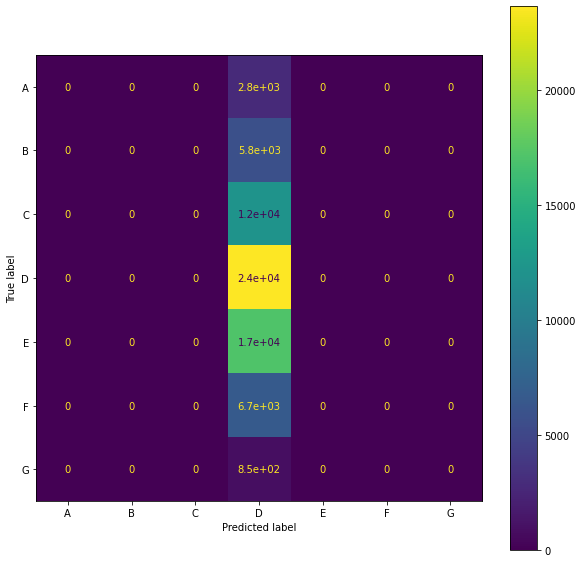

time: 5.69 s (started: 2021-06-02 14:52:31 +00:00)


In [66]:
# Init MLflow client
mlflow.set_experiment('DPE-Baseline mean')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='Baseline Mean') as run:
    model = Baseline(params=params)

# Decision Tree Regressor


In [67]:
class DecisionTree(Model):
    """
    Class to train and tune decison tree regressor model.
    """

    def __init__(self, params):
        """
        Init class with model hyperparameters.
        """
        Model.__init__(self, params)
        self.model_name = "decision_trees"

        self.best_max_depth = None
        self.best_min_samples_split = None
        self.min_samples_leaf = None
        self.min_weight_fraction_leaf = None
        self.max_features = None
        self.max_leaf_nodes = None
        self.best_grid = None
        self.best_splitter = None

        self.run()


    def preprocessing(self):
        """
        Preprocessing dataset, includes encoding categorical features using a frequency encoder,
        dropping useless features and selecting the target.
        """
        self.logger.info('Starting Decision tree preprocessing...')
        encoding = self.dataset.groupby('code_departement').size()
        encoding = encoding/len(self.dataset)
        self.dataset['code_departement'] = self.dataset.code_departement.map(encoding)

        super().preprocessing()

    
    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        self.logger.info('Starting hyperparameter tuning...')
        # Grid parameters 
        params = {
                'max_depth': [5, 8, 10],
                'min_samples_split' : [10, 100],
                'min_samples_leaf':[1,2],
                'min_weight_fraction_leaf':[0.0, 0.1],
                'max_features':["auto","log2","sqrt",None],
                'max_leaf_nodes':[None,10], 
                'criterion': ['mse'], 
                'splitter':["best"],
                }

        # Grid search
        tree = DecisionTreeRegressor()
        grid = GridSearchCV(tree, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train)

        # Assign the best parameters
        self.best_max_depth = grid.best_params_['max_depth']
        self.best_min_samples_split = grid.best_params_['min_samples_split']
        self.best_max_leaf_nodes = grid.best_params_['max_leaf_nodes']
        self.best_max_features = grid.best_params_['max_features']
        self.best_min_weight_fraction_leaf = grid.best_params_['min_weight_fraction_leaf']
        self.best_min_samples_leaf = grid.best_params_['min_samples_leaf']
        self.best_criterion = grid.best_params_['criterion'] 
        self.best_splitter = grid.best_params_['splitter']
            
        # Log the best parameters to Mlflow
        self.logger.info('Logging best parameters to MLFlow...')
        mlflow.log_param(f'best_max_depth', self.best_max_depth) 
        mlflow.log_param(f'best_min_samples_split', self.best_min_samples_split)
        mlflow.log_param(f'best_max_leaf_nodes', self.best_max_leaf_nodes)
        mlflow.log_param(f'best_max_features', self.best_max_features)
        mlflow.log_param(f'best_min_weight_fraction_leaf', self.best_min_weight_fraction_leaf)
        mlflow.log_param(f'best_min_samples_leaf', self.best_min_samples_leaf)
        mlflow.log_param(f'best_criterion', self.best_criterion)
        mlflow.log_param(f'best_splitter', self.best_splitter)

        self.logger.info('Hyperparameter tuning finished!!!')

        
    def train_model(self):
        """
        Train model with best hyper-parameters from the grid search.
        """
        self.logger.info('Starting training...')
        self.model = DecisionTreeRegressor(max_depth=self.best_max_depth, min_samples_split=self.best_min_samples_split,
                                        splitter=self.best_splitter, criterion=self.best_criterion)
        # Fit model
        self.logger.info('Fitting final model...')
        self.model.fit(self.X_train, self.y_train) 
        # Predict values
        self.logger.info('Predicting...')
        self.y_pred = self.model.predict(self.X_test)
        self.logger.info('Modeling finished!!!')

time: 88.6 ms (started: 2021-06-02 14:52:56 +00:00)


INFO:Model:Running Model...
INFO:Model:Loading dataset...
INFO:Model:Dataset loaded!!!
INFO:Model:Starting Decision tree preprocessing...
INFO:Model:Starting preprocessing...
INFO:Model:Preprocessing finished!!!
INFO:Model:Starting train-test split...
INFO:Model:Train-test split finished!!!
INFO:Model:Starting hyperparameter tuning...
INFO:Model:Logging best parameters to MLFlow...
INFO:Model:Hyperparameter tuning finished!!!
INFO:Model:Starting training...
INFO:Model:Fitting final model...
INFO:Model:Predicting...
INFO:Model:Modeling finished!!!
INFO:Model:Modeling finished!!!
INFO:Pipeline:Running Pipeline...
INFO:Pipeline:Starting K-fold validation...
INFO:Pipeline:K-fold validation finished !!!
INFO:Pipeline:Starting model evaluation...
INFO:Pipeline:Model evaluation finished!!!
INFO:Pipeline:Starting logging confusion matrix...
INFO:Pipeline:Logging confusion matrix finished!!!
INFO:Pipeline:Starting saving model...
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._Colorbar

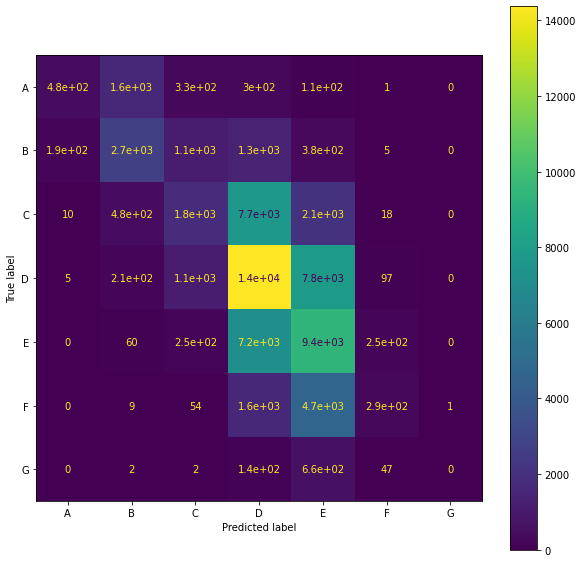

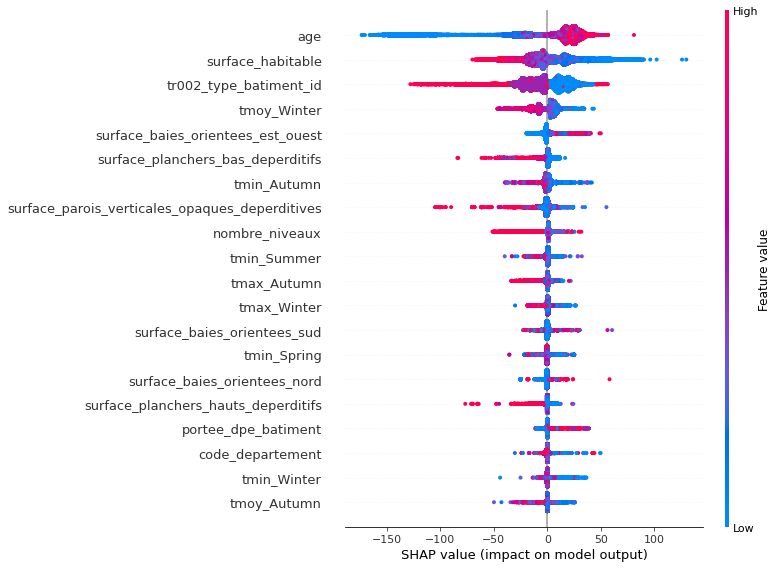

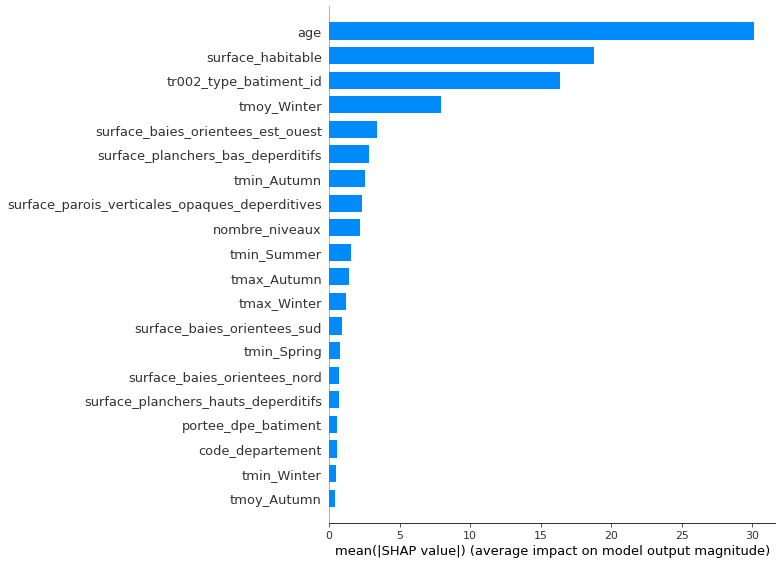

time: 20min 25s (started: 2021-06-02 14:52:58 +00:00)


In [68]:
# Init MLflow client
mlflow.set_experiment('DPE-Decision-Trees')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='Decision Tree Regression') as run:
    model = DecisionTree(params=params)
    pipeline = Pipeline(params=params, model=model)

# LightGBM

* **Light GBM** is a gradient boosting framework that uses tree based learning algorithm.


* Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.


* We chose LightGBM because of its high speed, because it can handle large datasets and it takes lower memory to run. It also focuses on accuracy of results.


* For hyperparameter tuning, we chose a **Bayesian hyperparameter Optimization** approach which builds a probability model of the objective function and uses it to select the most promising hyperparameters to evaluate in the true objective function. Here we use gaussian process-based optimisation.

* Let's start by splitting the train set into a train set and a validation set. We don't use the test set in the hyper-parameter optimization to avoid any leak :

In [69]:
class LightGBM(Model):
    """
    Class to train and tune a lightgbm model.
    """

    def __init__(self, params):

        Model.__init__(self, params)
        self.model_name = "LightGBM"

        self.cat_features = None
        self.best_metric = None
        self.best_n_estimators = None
        self.num_leaves = None
        self.learning_rate = None
        self.boosting_type = None
        self.best_max_depth = None
        
        self.run()


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        super().load_dataset()


    def preprocessing(self):
        """
        Preprocessing dataset, includes casting categorical features,
        dropping useless features and selecting the target.
        """
        self.logger.info('Starting LightGBM preprocessing...')
        self.dataset['code_departement'] = self.dataset['code_departement'].astype('category')
        self.dataset['tr002_type_batiment_id'] = self.dataset['tr002_type_batiment_id'].astype('category')
        
        super().preprocessing()


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        super().train_test_split()

    
    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        self.logger.info('Starting hyperparameter tuning...')
        # Assign categorical features
        self.cat_features = ['code_departement', 'tr002_type_batiment_id']

        # Parameters 
        params = {
                'task': ['train'],
                'boosting_type': ['gbdt'],#, 'rf'
                'objective': ['regression'],
                'metric': ['l2'],#auc
                'learning_rate': [0.005], #0.01
                'feature_fraction': [0.9],
                'bagging_fraction': [0.7],
                'bagging_freq': [10],
                'verbose': [0],
                'max_depth': [8, 10], #10, 12, 25
                'num_leaves': [128], #128, 250 
                'max_bin': [512],
                #"num_iterations": [100000],
                'n_estimators': [500], # 600
                'is_training_metric' : ['True']
                }

        # Grid search
        gbm = lgb.LGBMRegressor()
        grid = GridSearchCV(gbm, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train, categorical_feature=self.cat_features)

        # Assign the best parameters
        self.best_metric = grid.best_params_['metric']
        self.best_boosting_type = grid.best_params_['boosting_type']
        self.best_num_leaves = grid.best_params_['num_leaves']
        self.best_learning_rate = grid.best_params_['learning_rate']
        self.best_n_estimators = grid.best_params_['n_estimators']
        self.best_max_depth = grid.best_params_['max_depth']

        # Log the best parameters    
        mlflow.log_param(f'best_metric', self.best_metric)
        mlflow.log_param(f'best_boosting_type', self.best_boosting_type)
        mlflow.log_param(f'best_num_leaves', self.best_num_leaves)
        mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        mlflow.log_param(f'best_n_estimators', self.best_n_estimators)
        mlflow.log_param(f'best_max_depth', self.best_max_depth)

        self.logger.info('Hyperparameter tuning finished!!!')

        
    def train_model(self):
        """
        Train model with best hyper-parameters from the grid search.
        """
        self.logger.info('Starting training...')
        self.model = lgb.LGBMRegressor(metric=self.best_metric, n_estimators=self.best_n_estimators, num_leaves=self.num_leaves,
                                    boosting_type=self.boosting_type, learning_rate=self.learning_rate)
        # Fit model
        self.logger.info('Fitting final model...')
        self.model.fit(self.X_train, self.y_train, categorical_feature=self.cat_features) 
        # Predict values
        self.logger.info('Predicting...')
        self.y_pred = self.model.predict(self.X_test)
        self.logger.info('Modeling finished!!!')

time: 90.6 ms (started: 2021-06-02 15:23:35 +00:00)


INFO:Model:Running Model...
INFO:Model:Loading dataset...
INFO:Model:Dataset loaded!!!
INFO:Model:Starting LightGBM preprocessing...
INFO:Model:Starting preprocessing...
INFO:Model:Preprocessing finished!!!
INFO:Model:Starting train-test split...
INFO:Model:Train-test split finished!!!
INFO:Model:Starting hyperparameter tuning...
INFO:Model:Hyperparameter tuning finished!!!
INFO:Model:Starting training...
INFO:Model:Fitting final model...
INFO:Model:Predicting...
INFO:Model:Modeling finished!!!
INFO:Model:Modeling finished!!!
INFO:Pipeline:Running Pipeline...
INFO:Pipeline:Starting K-fold validation...
INFO:Pipeline:K-fold validation finished !!!
INFO:Pipeline:Starting model evaluation...
INFO:Pipeline:Model evaluation finished!!!
INFO:Pipeline:Starting logging confusion matrix...
INFO:Pipeline:Logging confusion matrix finished!!!
INFO:Pipeline:Starting saving model...
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1eb7f76810>
DEBUG:matplotli

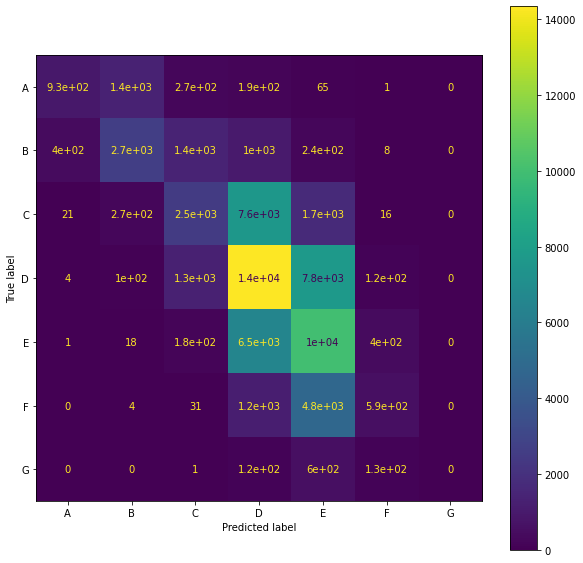

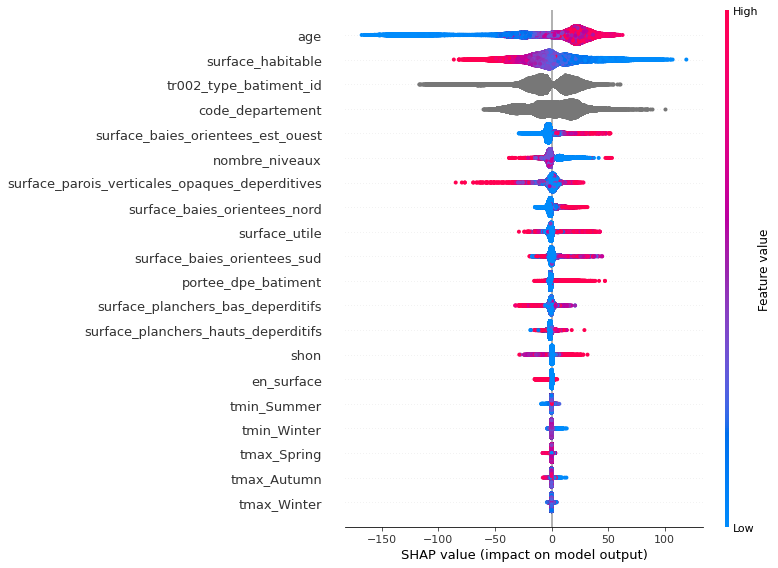

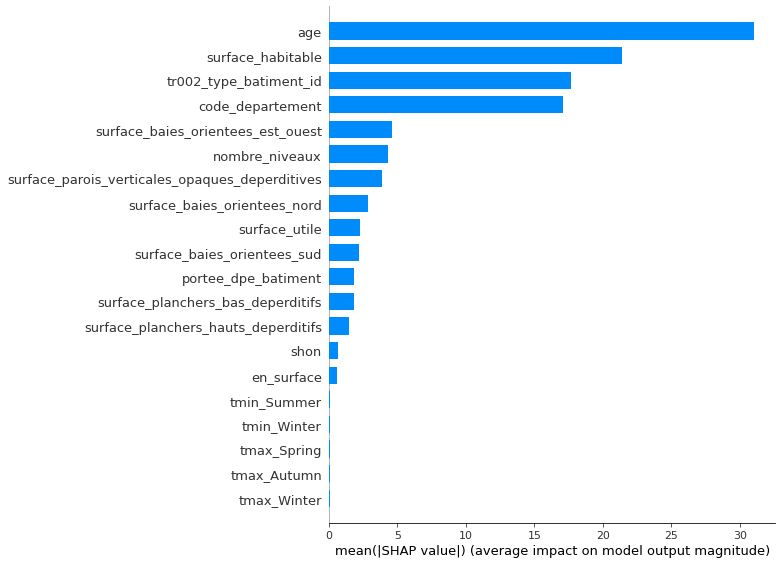

time: 22min 42s (started: 2021-06-02 15:23:38 +00:00)


In [70]:
# Init MLflow client
mlflow.set_experiment('DPE-LightGBM')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='LightGBM') as run:
    model = LightGBM(params=params)
    pipeline = Pipeline(params=params, model=model)

# Catboost

In [71]:
class CatBoost(Model):
    """
    Class to train and tune a CatBoost model.
    """

    def __init__(self, params):

        Model.__init__(self, params)
        self.model_name = "CatBoost"

        self.best_iterations = None
        self.best_depth = None
        self.learning_rate = None
        self.num_leaves = None
        self.boosting_type = None
        self.best_max_depth = None

        self.run()


    def load_dataset(self):
        """
        Load dataset into a pandas dataframe.
        """
        super().load_dataset()


    def preprocessing(self):
        """
        Preprocessing dataset, includes 
        dropping useless features and selecting the target.
        """
        self.logger.info('Starting CatBoost preprocessing...')
        super().preprocessing()


    def train_test_split(self):
        """
        Split data into train and test sets.
        """
        super().train_test_split()

    
    def parameter_tuning(self):
        """
        Hyperparameter tuning using grid search.
        """
        self.logger.info('Starting hyperparameter tuning...')
        # Assign categorical features
        index_1 = self.X_train.columns.get_loc('code_departement')
        index_2 = self.X_train.columns.get_loc('tr002_type_batiment_id')
        self.cat_features = ['tr002_type_batiment_id', 'code_departement']

        # Parameters 
        params = {
                'iterations': [100, 500],#500
                'learning_rate': [0.005],#, 0.01, 1
                'depth': [8, 10, 12] #, 10, 12, 25
                }
  
        # Grid search  
        cat = cgb.CatBoostRegressor(silent=True) 
        grid = GridSearchCV(cat, params, cv=self.params.k_folds)
        grid.fit(self.X_train, self.y_train, cat_features=self.cat_features)

        # Assign the best parameters
        self.best_metric = grid.best_params_['iterations']
        self.best_learning_rate = grid.best_params_['learning_rate']
        self.best_depth = grid.best_params_['depth']
        #self.best_num_leaves = grid.best_params_['num_leaves']
        #self.best_n_estimators = grid.best_params_['n_estimators']
        #self.best_max_depth = grid.best_params_['max_depth']

        # Log the best parameters   
        mlflow.log_param(f'best_iterations', self.best_iterations)
        mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        mlflow.log_param(f'best_depth', self.best_depth)
        #mlflow.log_param(f'best_learning_rate', self.best_learning_rate)
        #mlflow.log_param(f'best_n_estimators', self.best_n_estimators)
        #mlflow.log_param(f'best_max_depth', self.best_max_depth)

        self.logger.info('Hyperparameter tuning finished!!!')
        
        
    def train_model(self):
        """
        Train model with best hyper-parameters from the grid search.
        """
        self.logger.info('Starting training...')
        self.model = cgb.CatBoostRegressor(depth=self.best_depth, iterations=self.best_iterations, learning_rate=self.learning_rate, silent=True)
        # Fit model
        self.logger.info('Fitting final model...')
        self.model.fit(self.X_train, self.y_train, cat_features=self.cat_features) 
        # Predict values
        self.logger.info('Predicting...')
        self.y_pred = self.model.predict(self.X_test)
        self.logger.info('Modeling finished!!!')

time: 66.8 ms (started: 2021-06-02 15:49:10 +00:00)


In [ ]:
# Init MLflow client
mlflow.set_experiment('DPE-CatBoost')

params = Parameters()

# Start MLflow experiment
with mlflow.start_run(run_name='Catboost') as run:
    model = CatBoost(params=params)
    pipeline = Pipeline(params=params, model=model)

INFO:Model:Running Model...
INFO:Model:Loading dataset...
INFO:Model:Dataset loaded!!!
INFO:Model:Starting CatBoost preprocessing...
INFO:Model:Starting preprocessing...
INFO:Model:Preprocessing finished!!!
INFO:Model:Starting train-test split...
INFO:Model:Train-test split finished!!!
INFO:Model:Starting hyperparameter tuning...
INFO:Model:Hyperparameter tuning finished!!!
INFO:Model:Starting training...
INFO:Model:Fitting final model...
INFO:Model:Predicting...
INFO:Model:Modeling finished!!!
INFO:Model:Modeling finished!!!
INFO:Pipeline:Running Pipeline...
INFO:Pipeline:Starting K-fold validation...
INFO:Pipeline:K-fold validation finished !!!
INFO:Pipeline:Starting model evaluation...
INFO:Pipeline:Model evaluation finished!!!
INFO:Pipeline:Starting logging confusion matrix...
INFO:Pipeline:Logging confusion matrix finished!!!
INFO:Pipeline:Starting saving model...
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1ec3c8ee10>
DEBUG:matplotli

# MLflow API

In [40]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1sCdZL0vOhPokZP6r1uZFcIG2B5_2AGxAFTUesCxw3MDWPEdw"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://d79c69688ab2.ngrok.io
time: 1.37 s (started: 2021-06-01 14:30:05 +00:00)


In [41]:
!mlflow ui

[2021-06-01 14:30:09 +0000] [3092] [INFO] Starting gunicorn 20.1.0
[2021-06-01 14:30:09 +0000] [3092] [INFO] Listening at: http://127.0.0.1:5000 (3092)
[2021-06-01 14:30:09 +0000] [3092] [INFO] Using worker: sync
[2021-06-01 14:30:09 +0000] [3095] [INFO] Booting worker with pid: 3095
[2021-06-01 14:31:28 +0000] [3092] [INFO] Handling signal: int

Aborted!
[2021-06-01 14:31:28 +0000] [3095] [INFO] Worker exiting (pid: 3095)
[2021-06-01 14:31:28 +0000] [3092] [INFO] Shutting down: Master
time: 1min 22s (started: 2021-06-01 14:30:07 +00:00)


# Save mlruns to drive

In [ ]:
!zip -r /content/mlruns.zip  /content/mlruns

In [ ]:
shutil.move("/content/mlruns", "/content/drive/MyDrive/MVP/DPE/mlflow/mlruns")

'/content/drive/MyDrive/MVP/DPE/mlflow/mlruns'

time: 3.83 s (started: 2021-05-10 16:32:14 +00:00)
